<a href="https://colab.research.google.com/github/Voyageran/StartNN/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/content/notebooks/colabInstallPackage")

!cp -av '/content/gdrive/MyDrive/Colab Notebooks/d2l' '/content/'

Mounted at /content/gdrive
'/content/gdrive/MyDrive/Colab Notebooks/d2l' -> '/content/d2l'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/paddle.py' -> '/content/d2l/paddle.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/mxnet.py' -> '/content/d2l/mxnet.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/tensorflow.py' -> '/content/d2l/tensorflow.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/torch.py' -> '/content/d2l/torch.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__init__.py' -> '/content/d2l/__init__.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__' -> '/content/d2l/__pycache__'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/mxnet.cpython-310.pyc' -> '/content/d2l/__pycache__/mxnet.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/__init__.cpython-310.pyc' -> '/content/d2l/__pycache__/__init__.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/torch.cpython-310.pyc' -> '/content/d2l/__pycache__/torch.cpython-

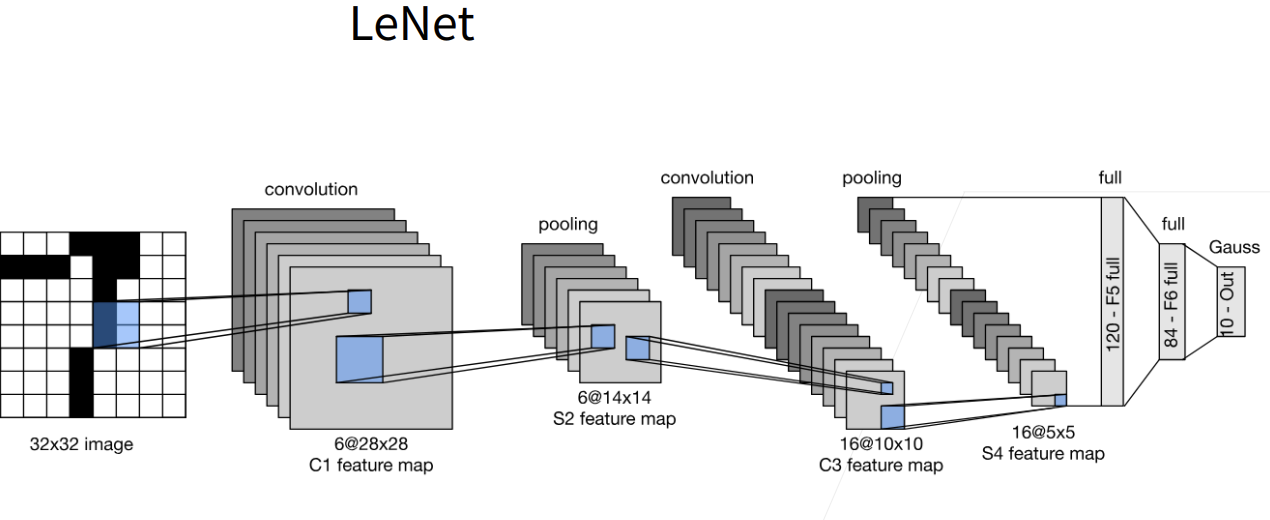

两个部分组成：卷积编码器和全连接层密集块

In [45]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
  def forward(self, x): #for input data
    return x.view(-1,1,28,28)   #批量数不变，通道数1，填充前大小28*28，填充后32*32

net = torch.nn.Sequential(
    Reshape(), nn.Conv2d(1,6,kernel_size=5, padding=2), nn.Sigmoid(), #32-5+1=28
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6,16, kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2), nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(), #400=16*5*5
    nn.Linear(120,84), nn.Sigmoid(),
    nn.Linear(84,10)
)

In [46]:
X = torch.rand(size=(1,1,28,28), dtype = torch.float32)
# X

#看內部變化
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [47]:
# performance on the Fashion-MNIST dataset
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size = batch_size)

100%|██████████| 26421880/26421880 [00:02<00:00, 11071119.50it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 197321.99it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3689919.79it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6458952.14it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [48]:
# LeNet CPU还是能跑跑的
def evaluate_accuracy_gpu(net, data_iter, device = None):
  """使用GPU计算模型在数据集上的精度"""
  if isinstance(net, torch.nn.Module):
    net.eval() #变成eval的module
    if not device:
      device = next(iter(net.parameters())).device #把model第一个参数拿出来看下它的device在哪里
  metric = d2l.Accumulator(2) #累加器
  for X, y in data_iter:
    if isinstance(X, list):
      X = [x.to(device) for x in X]
    else:
      X = X.to(device)
    y = y.to(device)
    metric.add(d2l.accuracy(net(X), y), y.numel())  #numel(): number of elements

    return metric[0]/metric[1] # right classification / misclassification

`model.eval()`的作用是**不启用** Batch Normalization 和 Dropout。

如果模型中有BN层(Batch Normalization）和Dropout，在测试时添加`model.eval()`。`model.eval()`是保证BN层能够用全部训练数据的均值和方差，即测试过程中要保证BN层的均值和方差不变。对于Dropout，`model.eval()`是利用到了所有网络连接，即不进行随机舍弃神经元。

训练完train样本后，生成的模型model要用来测试样本。在model(test)之前，需要加上`model.eval()`，否则的话，有输入数据，即使不训练，它也会改变权值。这是model中含有BN层和Dropout所带来的的性质。

`model.train()`的作用是**启用** Batch Normalization 和 Dropout。

如果模型中有BN层(Batch Normalization）和Dropout，需要在训练时添加model.train()。`model.train()`是保证BN层能够用到每一批数据的均值和方差。对于Dropout，`model.train()`是随机取一部分网络连接来训练更新参数。



In [ ]:
# Training function
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  """Train a model with a GPU """
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: #全连接层or卷积层
      nn.init.xavier_uniform_(m.weight) #初始函数根据输入输出的大小使得你的输入和输出方差差不多，保证你在模型开始时不爆炸或者变成0
  #应用在整个weight上面
  net.apply(init_weights)
  print('training on', device) #看看是不是真的在GPU上跑
  net.to(device)
  #SGD
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  #cross-entropy
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                          legend = ['train loss','train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)

  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X,y) in enumerate(train_iter):
      timer.start()
      optimizer.